In [30]:
import torch
import requests
from PIL import Image
from transformers import AutoModelForImageTextToText, AutoProcessor
import matplotlib.pyplot as plt
import gc

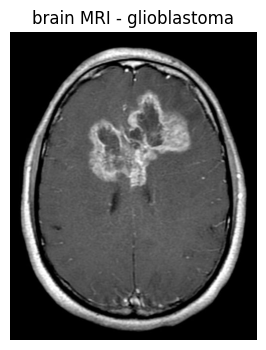

In [31]:
from io import BytesIO

url = "https://prod-images-static.radiopaedia.org/images/940/67dcac388ad1cc69f7252e9ab44516_big_gallery.jpeg"
image = Image.open(BytesIO(requests.get(url).content)).convert("RGB")

prompt = "What kind of scan is this? What pathology does the patient have? And what's their prognosis?"

report_text = (
    "This is an axial T1 -weighted postcontrast MRI (Magnetic Resonance Imaging) scan of the brain. "
    "The patient has a pathology called glioblastoma (GBM), which is a type of aggressive brain tumor. "
    "The prognosis for glioblastoma is generally poor, "
    "as it is a highly malignant tumor that tends to grow rapidly and invade surrounding brain tissue. "
    "Treatment options may include surgery, radiation therapy, and chemotherapy, "
    "but the overall survival rate for glioblastoma is low, "
    "with a median survival time of around 12 to 15 months after diagnosis. "
    "It's important to note that individual prognoses can vary depending on factors "
    "such as the patient's age, overall health, and the specific characteristics of the tumor."
)

messages = [
    {"role": "user", "content": [
        {"type": "image", "image": image},
        {"type": "text", "text": prompt},
    ]},
    {"role": "assistant", "content": [
        {"type": "text", "text": report_text},
    ]},
]

plt.figure(figsize=(4, 4))
plt.imshow(image)
plt.axis("off")
plt.title("brain MRI - glioblastoma")
plt.show()

In [32]:
model_id = "google/medgemma-4b-it"

processor = AutoProcessor.from_pretrained(model_id)
model = AutoModelForImageTextToText.from_pretrained(
    model_id,
    dtype=torch.bfloat16,
    device_map="auto",
)
model.eval()
print("loaded")

Loading weights: 100%|██████████| 883/883 [00:02<00:00, 316.84it/s, Materializing param=model.vision_tower.vision_model.post_layernorm.weight]                      


loaded


In [33]:
formatted = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=False)
print(repr(formatted))

"<bos><start_of_turn>user\n<start_of_image>What kind of scan is this? What pathology does the patient have? And what's their prognosis?<end_of_turn>\n<start_of_turn>model\nThis is an axial T1 -weighted postcontrast MRI (Magnetic Resonance Imaging) scan of the brain. The patient has a pathology called glioblastoma (GBM), which is a type of aggressive brain tumor. The prognosis for glioblastoma is generally poor, as it is a highly malignant tumor that tends to grow rapidly and invade surrounding brain tissue. Treatment options may include surgery, radiation therapy, and chemotherapy, but the overall survival rate for glioblastoma is low, with a median survival time of around 12 to 15 months after diagnosis. It's important to note that individual prognoses can vary depending on factors such as the patient's age, overall health, and the specific characteristics of the tumor.<end_of_turn>\n"


In [34]:
inputs = processor.apply_chat_template(
    messages,
    tokenize=True,
    return_dict=True,
    return_tensors="pt",
    add_generation_prompt=False,
).to(model.device)

tokens = processor.tokenizer.convert_ids_to_tokens(inputs["input_ids"][0].cpu().tolist())

# find "<start_of_turn>" followed by "model" in the actual token sequence
for i, tok in enumerate(tokens):
    if tok == "<start_of_turn>" and i + 1 < len(tokens) and tokens[i + 1] == "model":
        assistant_start = i + 3  # skip <start_of_turn> model \n
        break

print(f"total tokens: {len(tokens)}")
print(f"assistant starts at token: {assistant_start}")
print(f"\naround the boundary:")
for i in range(assistant_start - 4, assistant_start + 4):
    marker = " <--" if i == assistant_start else ""
    print(f"  [{i}] {tokens[i]}{marker}")

total tokens: 438
assistant starts at token: 289

around the boundary:
  [285] 

  [286] <start_of_turn>
  [287] model
  [288] 

  [289] This <--
  [290] ▁is
  [291] ▁an
  [292] ▁axial


In [40]:
inputs['pixel_values'].shape

torch.Size([1, 3, 896, 896])

In [38]:
inputs

{'input_ids': tensor([[     2,    105,   2364,    109, 255999, 262144, 262144, 262144, 262144,
         262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144,
         262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144,
         262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144,
         262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144,
         262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144,
         262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144,
         262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144,
         262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144,
         262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144,
         262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144,
         262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144, 262144,
         26214

In [6]:
with torch.no_grad():
    outputs = model(**inputs, output_hidden_states=True)

medgemma_hs = tuple(
    h[:, assistant_start:, :].detach().cpu().float()
    for h in outputs.hidden_states
)

print(f"layers: {len(medgemma_hs)}")
print(f"hidden dim: {medgemma_hs[-1].shape[-1]}")
print(f"assistant tokens: {medgemma_hs[0].shape[1]}")

# sanity check
decoded = processor.tokenizer.decode(inputs["input_ids"][0, assistant_start:].cpu().tolist())
print(f"\ndecoded assistant tokens:\n{decoded}")

layers: 35
hidden dim: 2560
assistant tokens: 149

decoded assistant tokens:
This is an axial T1 -weighted postcontrast MRI (Magnetic Resonance Imaging) scan of the brain. The patient has a pathology called glioblastoma (GBM), which is a type of aggressive brain tumor. The prognosis for glioblastoma is generally poor, as it is a highly malignant tumor that tends to grow rapidly and invade surrounding brain tissue. Treatment options may include surgery, radiation therapy, and chemotherapy, but the overall survival rate for glioblastoma is low, with a median survival time of around 12 to 15 months after diagnosis. It's important to note that individual prognoses can vary depending on factors such as the patient's age, overall health, and the specific characteristics of the tumor.<end_of_turn>



In [7]:
del model, outputs, inputs
gc.collect()
torch.cuda.empty_cache()
print(f"GPU mem: {torch.cuda.memory_allocated()/1e9:.1f} GB")

GPU mem: 0.0 GB


In [8]:
base_id = "google/gemma-3-4b-it"
base_processor = AutoProcessor.from_pretrained(base_id)
base_model = AutoModelForImageTextToText.from_pretrained(
    base_id,
    dtype=torch.bfloat16,
    device_map="auto",
)
base_model.eval()

base_formatted = base_processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=False)
base_inputs = base_processor.apply_chat_template(
    messages,
    tokenize=True,
    return_dict=True,
    return_tensors="pt",
    add_generation_prompt=False,
).to(base_model.device)

base_prefix = base_formatted.split("<start_of_turn>model\n")[0] + "<start_of_turn>model\n"
base_assistant_start = len(base_processor.tokenizer.encode(base_prefix))

print(f"total tokens: {base_inputs['input_ids'].shape[1]}")
print(f"assistant starts at token: {base_assistant_start}")

with torch.no_grad():
    base_outputs = base_model(**base_inputs, output_hidden_states=True)

gemma_hs = tuple(
    h[:, base_assistant_start:, :].detach().cpu().float()
    for h in base_outputs.hidden_states
)

print(f"layers: {len(gemma_hs)}, assistant tokens: {gemma_hs[0].shape[1]}")

del base_model, base_outputs, base_inputs
gc.collect()
torch.cuda.empty_cache()

Loading weights: 100%|██████████| 883/883 [00:10<00:00, 83.74it/s, Materializing param=model.vision_tower.vision_model.post_layernorm.weight]                       


total tokens: 438
assistant starts at token: 32
layers: 35, assistant tokens: 406


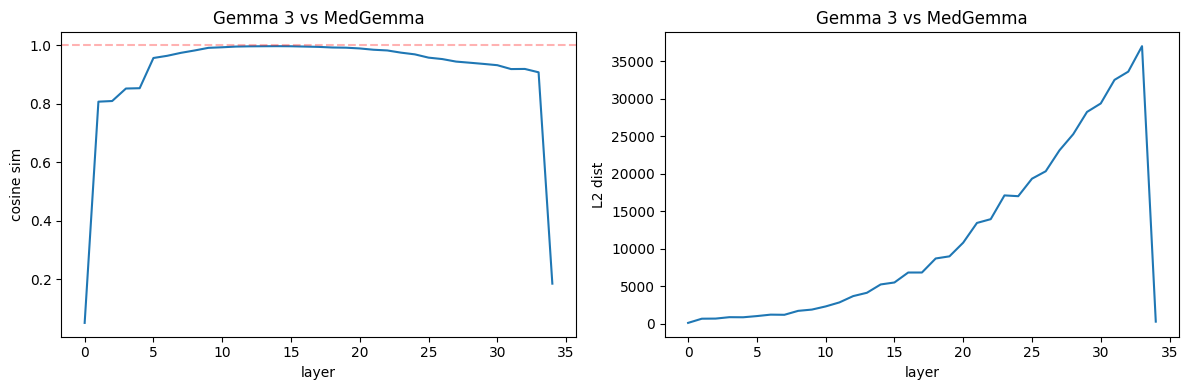

Layer 0 cosine: 0.0510
Last layer cosine: 0.1851


In [9]:
n_layers = min(len(medgemma_hs), len(gemma_hs))
seq_len = min(medgemma_hs[0].shape[1], gemma_hs[0].shape[1])

cosine_sims = []
l2_dists = []

for i in range(n_layers):
    m = medgemma_hs[i][0, :seq_len]
    g = gemma_hs[i][0, :seq_len]
    cosine_sims.append(torch.nn.functional.cosine_similarity(m, g, dim=-1).mean().item())
    l2_dists.append((m - g).norm(dim=-1).mean().item())

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(cosine_sims)
ax1.set_xlabel("layer"); ax1.set_ylabel("cosine sim"); ax1.set_title("Gemma 3 vs MedGemma")
ax1.axhline(y=1.0, color="r", linestyle="--", alpha=0.3)
ax2.plot(l2_dists)
ax2.set_xlabel("layer"); ax2.set_ylabel("L2 dist"); ax2.set_title("Gemma 3 vs MedGemma")
plt.tight_layout()
plt.show()

print(f"Layer 0 cosine: {cosine_sims[0]:.4f}")
print(f"Last layer cosine: {cosine_sims[-1]:.4f}")

In [10]:
for name, hs in [("MedGemma", medgemma_hs), ("Gemma 3", gemma_hs)]:
    last = hs[-1][0]
    mid = hs[len(hs)//2][0]
    print(f"\n{name} last:  mean={last.mean():.4f}  std={last.std():.4f}")
    print(f"{name} mid:   mean={mid.mean():.4f}  std={mid.std():.4f}")


MedGemma last:  mean=0.0747  std=3.7330
MedGemma mid:   mean=13.2988  std=612.6840

Gemma 3 last:  mean=0.0618  std=4.1728
Gemma 3 mid:   mean=11.4565  std=563.0125


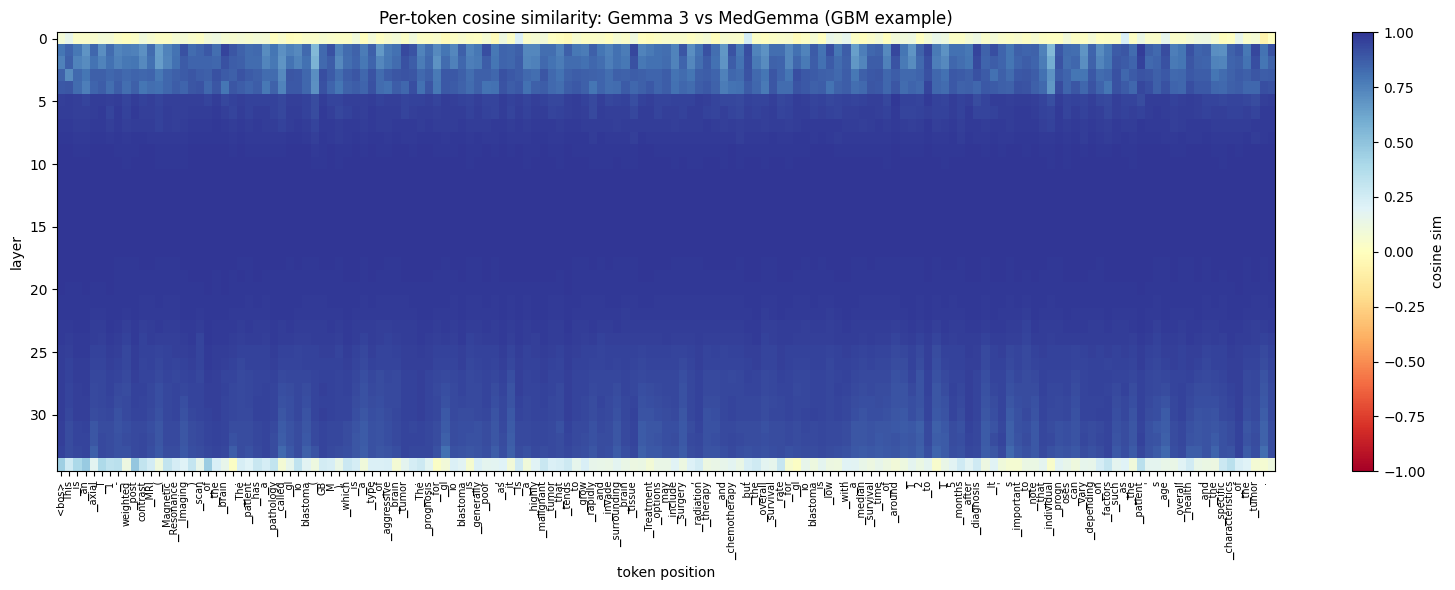

In [11]:
# use example 2 (GBM)
n_layers = min(len(medgemma_hs), len(gemma_hs))
seq_len = min(medgemma_hs[0].shape[1], gemma_hs[0].shape[1])

# build (layers x tokens) cosine sim matrix
cos_matrix = torch.zeros(n_layers, seq_len)
for i in range(n_layers):
    m = medgemma_hs[i][0, :seq_len]
    g = gemma_hs[i][0, :seq_len]
    cos_matrix[i] = torch.nn.functional.cosine_similarity(m, g, dim=-1)

# get token labels for x-axis
tokens2 = processor.tokenizer.convert_ids_to_tokens(
    processor.tokenizer.encode(report_text)
)[:seq_len]

fig, ax = plt.subplots(figsize=(16, 6))
im = ax.imshow(cos_matrix.numpy(), aspect="auto", cmap="RdYlBu", vmin=-1, vmax=1)
ax.set_xlabel("token position")
ax.set_ylabel("layer")
ax.set_title("Per-token cosine similarity: Gemma 3 vs MedGemma (GBM example)")
ax.set_xticks(range(len(tokens2)))
ax.set_xticklabels(tokens2, rotation=90, fontsize=7)
plt.colorbar(im, label="cosine sim")
plt.tight_layout()
plt.show()

In [12]:
last_layer_cos = cos_matrix[-1]
sorted_idx = last_layer_cos.argsort()

print("MOST DIVERGENT tokens at final layer:")
for i in sorted_idx[:10]:
    print(f"  [{i:3d}] {tokens2[i]:20s}  cosine={last_layer_cos[i]:.4f}")

print("\nMOST SIMILAR tokens at final layer:")
for i in sorted_idx[-10:]:
    print(f"  [{i:3d}] {tokens2[i]:20s}  cosine={last_layer_cos[i]:.4f}")

MOST DIVERGENT tokens at final layer:
  [ 21] .                     cosine=0.0166
  [ 90] ▁gl                   cosine=0.0182
  [ 46] ▁for                  cosine=0.0274
  [121] ▁individual           cosine=0.0451
  [107] ▁                     cosine=0.0531
  [ 89] ▁for                  cosine=0.0593
  [ 50] ▁is                   cosine=0.0606
  [147] .                     cosine=0.0649
  [117] ▁important            cosine=0.0668
  [116] s                     cosine=0.0683

MOST SIMILAR tokens at final layer:
  [  6] 1                     cosine=0.3269
  [143] ▁characteristics      cosine=0.3362
  [  7] ▁-                    cosine=0.3371
  [132] ▁patient              cosine=0.3408
  [  5] ▁T                    cosine=0.3844
  [  2] ▁is                   cosine=0.3921
  [  0] <bos>                 cosine=0.4425
  [ 18] ▁of                   cosine=0.4486
  [  3] ▁an                   cosine=0.4684
  [  9] ▁post                 cosine=0.4792


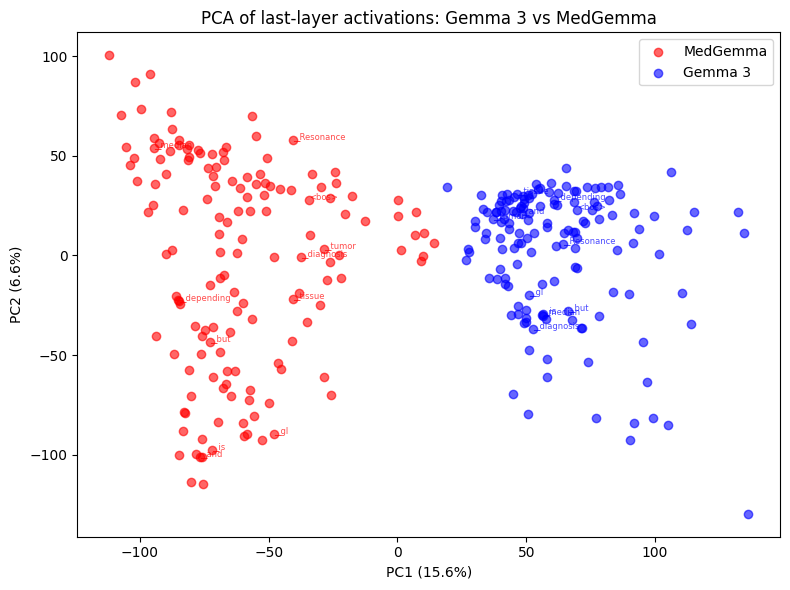

In [13]:
import numpy as np
from sklearn.decomposition import PCA

m_last = medgemma_hs[-1][0, :seq_len].numpy()
g_last = gemma_hs[-1][0, :seq_len].numpy()

combined = np.concatenate([m_last, g_last], axis=0)
pca = PCA(n_components=2)
projected = pca.fit_transform(combined)

m_proj = projected[:seq_len]
g_proj = projected[seq_len:]

plt.figure(figsize=(8, 6))
plt.scatter(m_proj[:, 0], m_proj[:, 1], c="red", alpha=0.6, label="MedGemma")
plt.scatter(g_proj[:, 0], g_proj[:, 1], c="blue", alpha=0.6, label="Gemma 3")

# annotate a few interesting tokens
for i in range(0, seq_len, max(1, seq_len // 10)):
    plt.annotate(tokens2[i], m_proj[i], fontsize=6, color="red", alpha=0.7)
    plt.annotate(tokens2[i], g_proj[i], fontsize=6, color="blue", alpha=0.7)

plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%})")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%})")
plt.title("PCA of last-layer activations: Gemma 3 vs MedGemma")
plt.legend()
plt.tight_layout()
plt.show()

In [14]:
m_mean = medgemma_hs[-1][0, :seq_len].mean(dim=0)
g_mean = gemma_hs[-1][0, :seq_len].mean(dim=0)
diff = (m_mean - g_mean).abs()

top_dims = diff.argsort(descending=True)[:20]
print("Top 20 most different hidden dimensions at last layer:")
print(f"{'dim':>6s}  {'|diff|':>10s}  {'medgemma':>10s}  {'gemma3':>10s}")
for d in top_dims:
    print(f"{d.item():6d}  {diff[d].item():10.2f}  {m_mean[d].item():10.2f}  {g_mean[d].item():10.2f}")

Top 20 most different hidden dimensions at last layer:
   dim      |diff|    medgemma      gemma3
  1293       27.43      -15.38       12.05
  1335       23.09      -13.35        9.75
  1698       22.19      -22.90       -0.71
  1209       13.04       11.06       -1.99
  1313       13.00      -11.41        1.59
  1398       12.80       18.24        5.44
  1477       12.29       -0.55      -12.85
  1709       11.48        3.94       -7.54
  2194       11.28      -10.39        0.89
  2429       10.95        4.77       -6.18
   109       10.55       -0.27       10.29
  1680        9.87        8.20       18.07
  2309        9.60        5.16       14.76
   514        9.17        3.11       -6.06
  1898        9.01        6.76       -2.25
  1402        8.78       -4.34        4.44
  2120        8.56        8.69        0.13
  2445        8.43       -2.60        5.83
  2421        8.16       -0.36       -8.52
  1791        7.91        6.39       -1.52


In [15]:
from transformers import AutoModelForImageTextToText
import torch

# load just the models (or if you still have them, skip this)
med_model = AutoModelForImageTextToText.from_pretrained(
    "google/medgemma-4b-it", torch_dtype=torch.bfloat16, device_map="cpu",
)
base_model = AutoModelForImageTextToText.from_pretrained(
    "google/gemma-3-4b-it", torch_dtype=torch.bfloat16, device_map="cpu",
)

# compare vision encoder weights
print("=== Vision Encoder ===")
for name, med_param in med_model.named_parameters():
    if "vision" not in name:
        continue
    base_param = dict(base_model.named_parameters())[name]
    diff = (med_param.float() - base_param.float()).abs().mean().item()
    cos = torch.nn.functional.cosine_similarity(
        med_param.float().flatten().unsqueeze(0),
        base_param.float().flatten().unsqueeze(0),
    ).item()
    if diff > 0.001:  # only print ones that changed
        print(f"  {name:60s}  mean_diff={diff:.4f}  cos={cos:.4f}")

# compare LLM weights
print("\n=== Language Model (sample layers) ===")
for name, med_param in med_model.named_parameters():
    if "vision" in name:
        continue
    base_param = dict(base_model.named_parameters())[name]
    diff = (med_param.float() - base_param.float()).abs().mean().item()
    if diff > 0.001:
        print(f"  {name:60s}  mean_diff={diff:.4f}")

`torch_dtype` is deprecated! Use `dtype` instead!
Loading weights:  69%|██████▉   | 611/883 [00:00<00:00, 1733.03it/s, Materializing param=model.vision_tower.vision_model.encoder.layers.10.layer_norm1.weight]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



  model.vision_tower.vision_model.encoder.layers.22.mlp.fc1.weight  mean_diff=0.0063  cos=0.8776
  model.vision_tower.vision_model.encoder.layers.22.mlp.fc1.bias  mean_diff=0.0030  cos=0.9999
  model.vision_tower.vision_model.encoder.layers.22.mlp.fc2.weight  mean_diff=0.0070  cos=0.8961
  model.vision_tower.vision_model.encoder.layers.22.mlp.fc2.bias  mean_diff=0.0568  cos=0.9939
  model.vision_tower.vision_model.encoder.layers.23.layer_norm1.weight  mean_diff=0.1633  cos=0.9926
  model.vision_tower.vision_model.encoder.layers.23.layer_norm1.bias  mean_diff=0.1155  cos=0.9672
  model.vision_tower.vision_model.encoder.layers.23.self_attn.k_proj.weight  mean_diff=0.0753  cos=0.1621
  model.vision_tower.vision_model.encoder.layers.23.self_attn.k_proj.bias  mean_diff=0.0195  cos=0.9992
  model.vision_tower.vision_model.encoder.layers.23.self_attn.v_proj.weight  mean_diff=0.0894  cos=0.1963
  model.vision_tower.vision_model.encoder.layers.23.self_attn.v_proj.bias  mean_diff=0.0311  cos=0.9

In [16]:
# medgemma vision encoder
processor = AutoProcessor.from_pretrained("google/medgemma-4b-it")
model = AutoModelForImageTextToText.from_pretrained(
    "google/medgemma-4b-it", torch_dtype=torch.bfloat16, device_map="auto",
)
model.eval()

pixel_values = processor.image_processor(images=image, return_tensors="pt")["pixel_values"].to(
    model.device, dtype=torch.bfloat16
)

with torch.no_grad():
    vision_out = model.model.vision_tower(pixel_values, output_hidden_states=True)

med_vision_hs = tuple(h.detach().cpu().float() for h in vision_out.hidden_states)
print(f"MedGemma vision: {len(med_vision_hs)} layers, shape {med_vision_hs[0].shape}")

del model
gc.collect()
torch.cuda.empty_cache()

Loading weights: 100%|██████████| 883/883 [00:02<00:00, 313.73it/s, Materializing param=model.vision_tower.vision_model.post_layernorm.weight]                      


MedGemma vision: 28 layers, shape torch.Size([1, 4096, 1152])


In [17]:
# base gemma vision encoder
base_processor = AutoProcessor.from_pretrained("google/gemma-3-4b-it")
base_model = AutoModelForImageTextToText.from_pretrained(
    "google/gemma-3-4b-it", torch_dtype=torch.bfloat16, device_map="auto",
)
base_model.eval()

pixel_values = base_processor.image_processor(images=image, return_tensors="pt")["pixel_values"].to(
    base_model.device, dtype=torch.bfloat16
)

with torch.no_grad():
    vision_out = base_model.model.vision_tower(pixel_values, output_hidden_states=True)

base_vision_hs = tuple(h.detach().cpu().float() for h in vision_out.hidden_states)
print(f"Gemma 3 vision: {len(base_vision_hs)} layers, shape {base_vision_hs[0].shape}")

del base_model
gc.collect()
torch.cuda.empty_cache()

Loading weights: 100%|██████████| 883/883 [00:02<00:00, 315.53it/s, Materializing param=model.vision_tower.vision_model.post_layernorm.weight]                      


Gemma 3 vision: 28 layers, shape torch.Size([1, 4096, 1152])


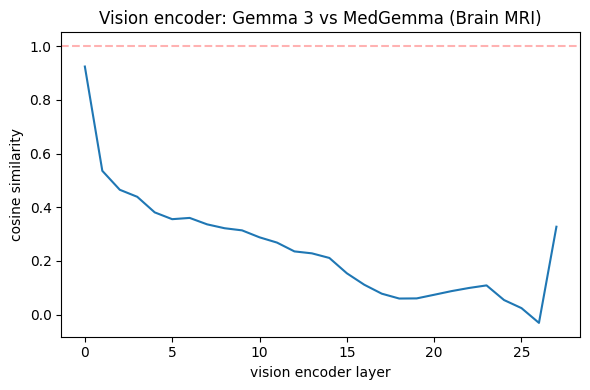

First layer: 0.9241
Last layer: 0.3274


In [18]:
# cosine sim per layer
n_layers = min(len(med_vision_hs), len(base_vision_hs))
cosines = []
for i in range(n_layers):
    m = med_vision_hs[i][0]
    g = base_vision_hs[i][0]
    cosines.append(torch.nn.functional.cosine_similarity(m, g, dim=-1).mean().item())

plt.figure(figsize=(6, 4))
plt.plot(cosines)
plt.xlabel("vision encoder layer")
plt.ylabel("cosine similarity")
plt.title("Vision encoder: Gemma 3 vs MedGemma (Brain MRI)")
plt.axhline(y=1.0, color="r", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

print(f"First layer: {cosines[0]:.4f}")
print(f"Last layer: {cosines[-1]:.4f}")

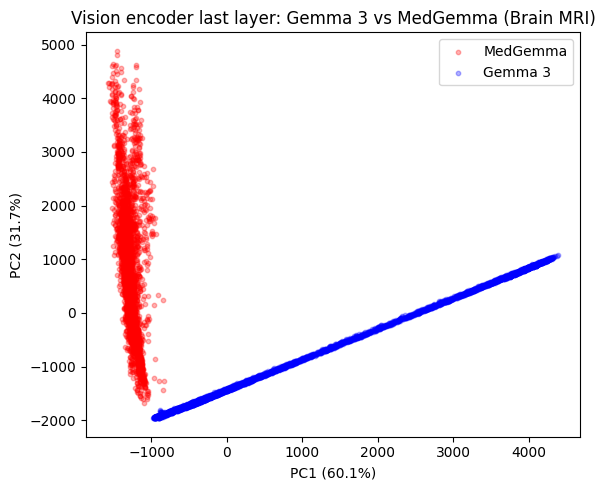

In [19]:
# PCA of last vision layer patches
from sklearn.decomposition import PCA
import numpy as np

m = med_vision_hs[-1][0].numpy()
g = base_vision_hs[-1][0].numpy()

combined = np.concatenate([m, g], axis=0)
pca = PCA(n_components=2)
proj = pca.fit_transform(combined)

n = m.shape[0]
plt.figure(figsize=(6, 5))
plt.scatter(proj[:n, 0], proj[:n, 1], c="red", alpha=0.3, s=10, label="MedGemma")
plt.scatter(proj[n:, 0], proj[n:, 1], c="blue", alpha=0.3, s=10, label="Gemma 3")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%})")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%})")
plt.title("Vision encoder last layer: Gemma 3 vs MedGemma (Brain MRI)")
plt.legend()
plt.tight_layout()
plt.show()